# 1. Clustering-Based Anomaly Detection: K-Means

## Concept & Theory

- The core idea behind using k-means for anomaly detection is to group data points into clusters. Normal data points will tend to be close to the center of a cluster (centroid), while anomalies will be far from any cluster centroid. The distance of a data point from its nearest cluster centroid can be used as an anomaly score.

1. **Clustering**: The k-means algorithm partitions the data into *k* clusters by minimizing the within-cluster sum of squares (WCSS):

    $$ \text{WCSS} = \sum_{i=1}^{k} \sum_{x \in C_i} ||x - \mu_i||^2 $$

    where $C_i$ is the $i$-th cluster and $\mu_i$ is its centroid.

2. **Anomaly Score**: For any data point $x$, its anomaly score is its Euclidean distance to the nearest centroid:

$$ \text{Anomaly Score}(x) = \min_{i=1,...,k} ||x - \mu_i||^2 $$

3. **Thresholding**: A threshold is set on the anomaly scores to classify points as anomalies. A common approach is to use a quantile of the distances.

## Python Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

### 1. Generate Sample Data

In [8]:
# Generate isotropic Gaussian blobs for clustering\n",
X, _ = make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=0)
print(X.shape)
# Add some outliers,
outliers = np.array([[0, 5],[6, 2]])
X = np.concatenate([X, outliers])


(300, 2)


### 2. Fit K-Means Model


In [9]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init=10).fit(X)

### 3. Calculate Anomaly Scores


In [10]:
# Calculate the distance from each point to its closest cluster center,
distances = np.min(kmeans.transform(X), axis=1)

# Set an anomaly threshold (e.g., 95th percentile),
threshold = np.quantile(distances, 0.95)

# Identify anomalies,
anomalies = X[distances > threshold]


### 4. Visualize Results


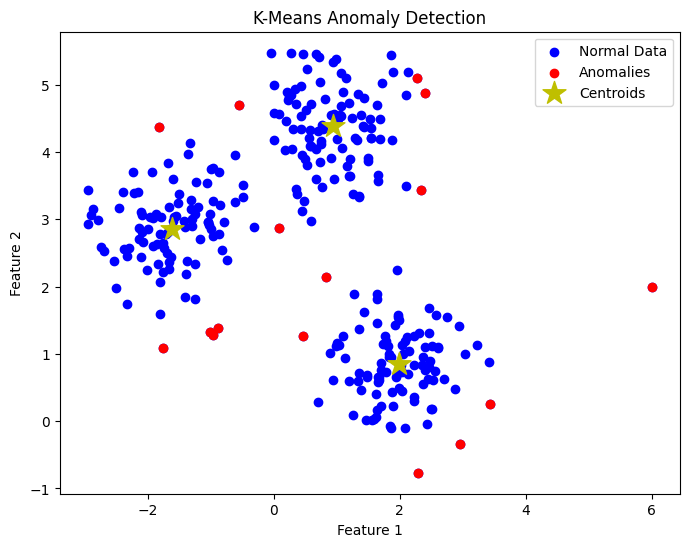

In [11]:
plt.figure(figsize=(8, 6)),
plt.scatter(X[:, 0], X[:, 1], c='b', label='Normal Data'),
plt.scatter(anomalies[:, 0], anomalies[:, 1], c='r', label='Anomalies'),
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='y', marker='*', label='Centroids'),
plt.title('K-Means Anomaly Detection'),
plt.xlabel('Feature 1'),
plt.ylabel('Feature 2'),
plt.legend(),
plt.show()


## Pros & Cons
### Pros
- **Simple and easy to implement.**: K-means is a well-understood algorithm.
- **Efficient**: It is computationally efficient for large datasets.
- **Scalable**: The algorithm scales well to a large number of samples.

### Cons
- **Requires specifying *k***: The number of clusters must be set beforehand.
- **Assumes spherical clusters**: K-means performs poorly on clusters with complex shapes.
- **Sensitive to initialization**: The initial placement of centroids can affect the final clustering

## When to Use
K-means is a good choice for anomaly detection when:
- The clusters are expected to be roughly spherical.
- The number of clusters (*k*) is known or can be estimated.
- The dataset is large and computational efficiency is important.


# 2. Clustering-Based Anomaly Detection: DBSCAN


## Concept & Theory
- DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a density-based clustering algorithm. The main idea is that a point is a core point if it has at least a minimum number of other points (MinPts) within a given radius (epsilon). Clusters are built by connecting core points that are close to each other. Points that are not part of any cluster are considered noise, which makes DBSCAN naturally suited for anomaly detection.

## Mathematical Overview

DBSCAN has two key parameters:

- **epsilon (eps)**: The radius of the neighborhood around a point.
- **MinPts**: The minimum number of points required to form a dense region.

Based on these parameters, points are classified as:

- **Core point**: A point that has at least MinPts points (including itself) in its eps-neighborhood.
- **Border point**: A point that is not a core point but is in the eps-neighborhood of a core point.
- **Noise point (Anomaly)**: A point that is neither a core point nor a border point. These are the points that are considered anomalies.

## Python Implementation


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons


### 1. Generate Sample Data


In [13]:
# Generate non-spherical data,
X, _ = make_moons(n_samples=300, noise=0.05, random_state=0)

# Add some outliers
outliers = np.array([[-1, 1.5], [2, 1]])
X = np.concatenate([X, outliers])


### 2. Fit DBSCAN Model


In [14]:
dbscan = DBSCAN(eps=0.2, min_samples=5).fit(X)


### 3. Identify Anomalies


In [15]:
# Anomalies are labeled as -1 by DBSCAN
anomalies = X[dbscan.labels_ == -1]


### 4. Visualize Results

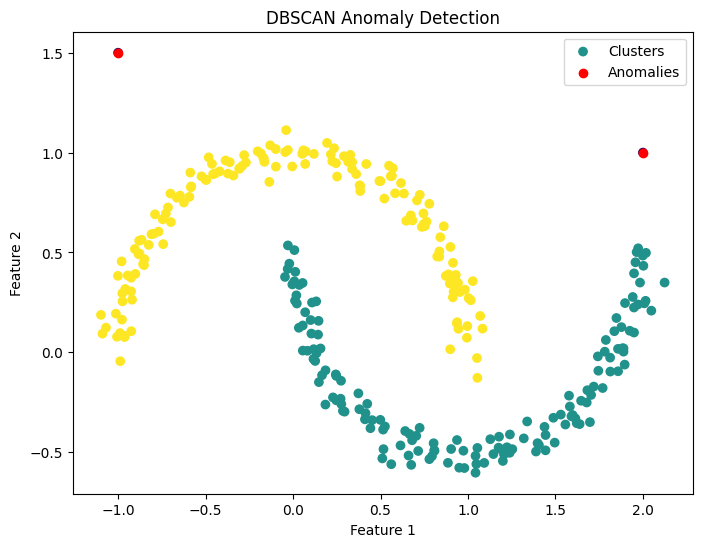

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=dbscan.labels_, cmap='viridis', label='Clusters')
plt.scatter(anomalies[:, 0], anomalies[:, 1], c='r', label='Anomalies')
plt.title('DBSCAN Anomaly Detection')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()


## Pros & Cons

### Pros

- **Can find arbitrarily shaped clusters.**: It is not limited to spherical clusters.
- **Does not require specifying the number of clusters.**: The algorithm finds the number of clusters on its own.
- **Robust to outliers**: DBSCAN is designed to identify and handle noise.

### Cons

- **Sensitive to parameters**: The choice of `eps` and `MinPts` can be difficult and has a large impact on the results.
- **Struggles with varying density**: It can be challenging to find a good set of parameters for clusters with varying densities.,
- **Curse of dimensionality**: The distance metric can be less meaningful in high-dimensional spaces.

## When to Use

DBSCAN is a good choice for anomaly detection when:
- The clusters have complex shapes.
- The number of clusters is unknown.
- The dataset contains noise and outliers that need to be identified.


# 3. Density-Based Anomaly Detection: Local Outlier Factor (LOF)


## Concept & Theory

Local Outlier Factor (LOF) is a density-based anomaly detection algorithm that measures the local deviation of the density of a given data point with respect to its neighbors. The core idea is to identify outliers by comparing the local density of a point to the local densities of its neighbors. Points in areas of lower density than their neighbors are considered outliers.


## Mathematical Overview

1. **k-distance**: The distance to the *k*-th nearest neighbor.

2. **Reachability distance**: The reachability distance of a point *A* from a point *B* is the maximum of the k-distance of *B* and the true distance between *A* and *B*.

$$ \text{reach-dist}_k(A, B) = \max(\text{k-distance}(B), d(A, B)) $$

3. **Local reachability density (lrd)**: The inverse of the average reachability distance of a point *A* from its neighbors.
$$ \text{lrd}_k(A) = 1 / \left( \frac{\sum_{B \in N_k(A)} \text{reach-dist}_k(A, B)}{|N_k(A)|} \right) $$

4. **Local outlier factor (LOF)**: The ratio of the average lrd of the neighbors of *A* to the lrd of *A*.
$$ \\text{LOF}_k(A) = \\frac{\\sum_{B \\in N_k(A)} \\frac{\\text{lrd}_k(B)}{\\text{lrd}_k(A)}}{|N_k(A)|} = \\frac{\\sum_{B \\in N_k(A)} \\text{lrd}_k(B)}{|N_k(A)|} / \\text{lrd}_k(A) $$

- A LOF score close to 1 means the point is in a dense region, while a score significantly greater than 1 indicates an outlier.



## Python Implementation


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.datasets import make_blobs


### 1. Generate Sample Data


In [18]:
# Generate isotropic Gaussian blobs for clustering,
X, _ = make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=0)
# Add some outliers,
outliers = np.array([[0, 5], [6, 2]])
X = np.concatenate([X, outliers])


### 2. Fit LOF Model


In [19]:
# novelty=True for outlier detection on new data,
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto', novelty=True).fit(X)


### 3. Identify Anomalies


In [20]:
# The predict method returns -1 for outliers and 1 for inliers.,
y_pred = lof.predict(X)
anomalies = X[y_pred == -1]


### 4. Visualize Results


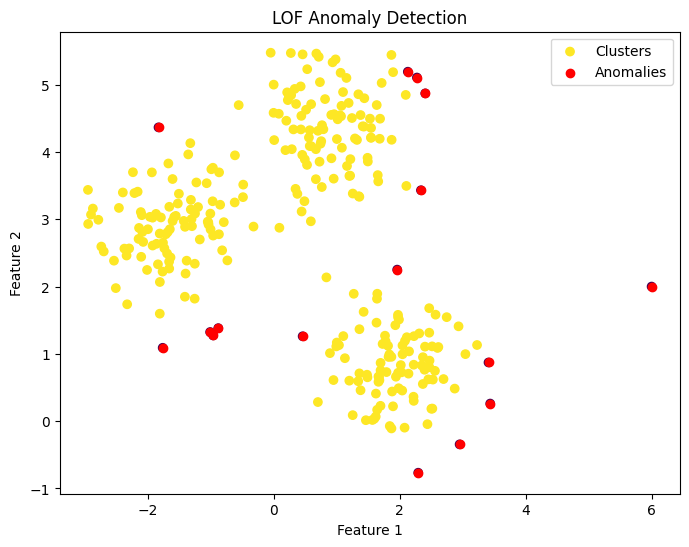

In [21]:
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='viridis', label='Clusters')
plt.scatter(anomalies[:, 0], anomalies[:, 1], c='r', label='Anomalies')
plt.title('LOF Anomaly Detection')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()


## Pros & Cons

### Pros

- **Effective in identifying local outliers.**: It can find outliers that have a different density than their neighbors.
- **No assumption about data distribution.**: It is a non-parametric method.
- **Works well with varying density clusters.**: It can handle clusters with different densities.

### Cons

- **Computationally expensive**: The calculation of the LOF score can be slow for large datasets.
- **Curse of dimensionality**: The distance metric can be less meaningful in high-dimensional spaces.
- **Parameter sensitive**: The choice of *k* (the number of neighbors) can be challenging.

## When to Use

LOF is a good choice for anomaly detection when:
- The dataset has clusters of varying densities.
- Outliers are expected to be local, meaning they are in regions of lower density than their neighbors.
- The dimensionality of the data is not excessively high.


# 4. Statistical Anomaly Detection: Gaussian Models


## Concept & Theory
The core idea behind using Gaussian models for anomaly detection is to fit a Gaussian distribution to the data. Data points that have a low probability under this distribution are considered anomalies. This method assumes that the normal data points are generated from a Gaussian distribution.


## Mathematical Overview

1. **Parameter Estimation**: We model the data using a multivariate Gaussian distribution with mean $\mu$ and covariance matrix $\Sigma$. These parameters are estimated from the data.
$$ \mu = \frac{1}{m} \sum_{i=1}^{m} x^{(i)} $$

$$\Sigma = \frac{1}{m} \sum_{i=1}^{m} (x^{(i)} - \mu)(x^{(i)} - \mu)^{T}$$

2. **Probability Density Function**: The probability of a data point *x* is given by:

$$ p(x; \mu, \Sigma) = \frac{1}{(2\pi)^{n/2} |\Sigma|^{1/2}} \exp\left(-\frac{1}{2}(x-\mu)^{T} \Sigma^{-1} (x-\mu)\right) $$

3. **Anomaly Detection**: We select a threshold $\epsilon$. If $p(x; \mu, \Sigma) < \epsilon$, the point is classified as an anomaly.


## Python Implementation


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.datasets import make_blobs


### 1. Generate Sample Data


In [23]:
# Generate isotropic Gaussian blobs for clustering
X, _ = make_blobs(n_samples=300, centers=1, cluster_std=1.0, random_state=0)

outliers = np.array([[5, 5], [-5, -5]])
X = np.concatenate([X, outliers])

### 2. Estimate Parameters


In [24]:
mu = np.mean(X, axis=0)
sigma = np.cov(X.T)


### 3. Calculate Probabilities


In [25]:
p = multivariate_normal.pdf(X, mean=mu, cov=sigma)


### 4. Identify Anomalies


In [26]:
# Set a threshold for anomaly detection
threshold = 1e-3
anomalies = X[p < threshold]


### 5. Visualize Results


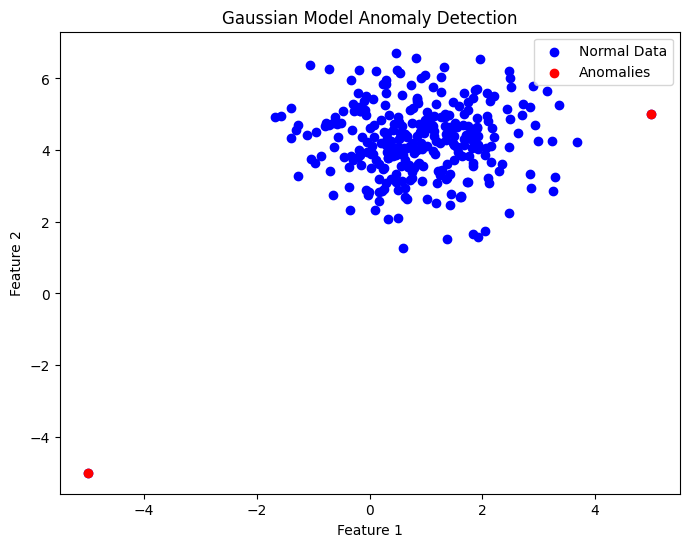

In [27]:
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c='b', label='Normal Data')
plt.scatter(anomalies[:, 0], anomalies[:, 1], c='r', label='Anomalies')
plt.title('Gaussian Model Anomaly Detection')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()


## Pros & Cons

### Pros

- **Computationally efficient**: The model is fast to train and evaluate.
- **Probabilistic approach**: It provides a probability score for each data point.
- **Easy to interpret**: The model is based on a well-understood statistical distribution.

### Cons

- **Assumes Gaussian distribution**: It performs poorly if the data is not Gaussian.
- **Sensitive to outliers in training data**: The parameter estimation can be skewed by outliers.
- **May not work well with multimodal distributions**: A single Gaussian may not be a good fit for data with multiple clusters.


Gaussian models are a good choice for anomaly detection when:
- The data is known to follow a Gaussian distribution.
- The dataset is not too large, and the number of features is not too high.
- A probabilistic interpretation of the anomaly score is desired.

# 5. Model-Based Anomaly Detection: Isolation Forest


## Concept & Theory

Isolation Forest is an ensemble-based anomaly detection algorithm. The core idea is that anomalies are \few and different\ and therefore easier to isolate than normal points. The algorithm builds an ensemble of isolation trees (iTrees) for the data. To isolate a data point, the algorithm recursively partitions the data until the point is isolated. The number of partitions required to isolate a point is its path length. Anomalies are expected to have shorter path lengths than normal points.


## Mathematical Overview

1. **iTree Construction**: An iTree is a binary tree where each node represents a partition of the data. A random feature and a random split value are chosen to partition the data at each node.
2. **Path Length**: The path length *h(x)* of a point *x* is the number of edges from the root of the iTree to the node where *x* is isolated.
3. **Anomaly Score**: The anomaly score *s(x, n)* for a point *x* is calculated as:
$$ s(x, n) = 2^{-\frac{E(h(x))}{c(n)}} $$
where *E(h(x))* is the average path length of *x* over all iTrees, and *c(n)* is the average path length of an unsuccessful search in a Binary Search Tree, given by:

$$ c(n) = 2H(n-1) - (2(n-1)/n) $$

where *H(i)* is the harmonic number, which can be estimated as *ln(i) + 0.5772156649* (Euler's constant).
- If the score is close to 1, the point is likely an anomaly.,
- If the score is less than 0.5, the point is likely a normal point.,
- If all scores are close to 0.5, then the entire sample does not seem to have any distinct anomalies.


## Python Implementation


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.datasets import make_blobs


### 1. Generate Sample Data


In [29]:
# Generate isotropic Gaussian blobs for clustering,
X, _ = make_blobs(n_samples=300, centers=1, cluster_std=1.0, random_state=0)

# Add some outliers,
outliers = np.array([[5, 5], [-5, -5]])
X = np.concatenate([X, outliers])


### 2. Fit Isolation Forest Model


In [30]:
# contamination='auto' is a good default,
iso_forest = IsolationForest(contamination='auto', random_state=0).fit(X)


### 3. Identify Anomalies


In [31]:
# The predict method returns -1 for outliers and 1 for inliers.
y_pred = iso_forest.predict(X)
anomalies = X[y_pred == -1]


### 4. Visualize Results


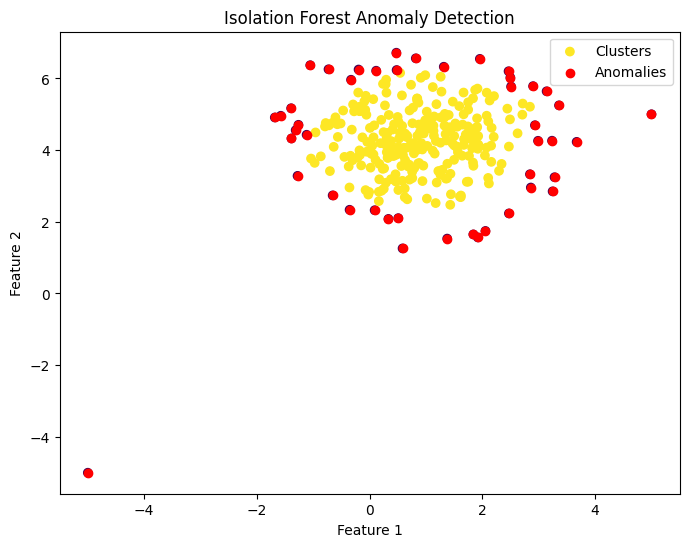

In [32]:
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='viridis', label='Clusters')
plt.scatter(anomalies[:, 0], anomalies[:, 1], c='r', label='Anomalies')
plt.title('Isolation Forest Anomaly Detection')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()


## Pros & Cons

### Pros
- **Efficient**: It has a low time complexity and is suitable for large datasets.
- **Handles high-dimensional data well**: It can be effective even with a large number of features.
- **No need to specify the number of clusters**: It does not require any cluster-related parameters.

### Cons,
- **Can be sensitive to the number of trees**: The performance can be affected by the number of iTrees in the forest.,
- **May not perform well on complex datasets**: It may struggle with datasets that have complex structures and no clear separation between normal and anomalous points.

## When to Use

Isolation Forest is a good choice for anomaly detection when:
- The dataset is large and high-dimensional.
- There is no prior knowledge about the data distribution.
- Anomalies are expected to be few and different from normal data.
